In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [7]:
def folder(f_name):
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [8]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))
    return files_add

In [9]:
ml_list = {
    "SVM": {
        "ACK": SVC(C=10.0, gamma=1, probability=True),
        "ARP": SVC(C=0.001, gamma=0.001, probability=True),
        "BF": SVC(C=10, gamma=1.0, probability=True),
        "HTTP": SVC(C=1, gamma=0.001, probability=True),
        "SP": SVC(C=10, gamma=1, probability=True),
        "SYN": SVC(C=10, gamma=1.0, probability=True),
        "UDP": SVC(C=1, gamma=1.0, probability=True),
    },
    "RF": {
        "ACK": RandomForestClassifier(
            bootstrap=True,
            criterion="entropy",
            max_depth=10,
            max_features=6,
            min_samples_split=3,
            n_estimators=41,
        ),
        "ARP": RandomForestClassifier(
            bootstrap=False,
            criterion="gini",
            max_depth=29,
            max_features=1,
            min_samples_split=4,
            n_estimators=166,
        ),
        "BF": RandomForestClassifier(
            bootstrap=True,
            criterion="gini",
            max_depth=22,
            max_features=7,
            min_samples_split=4,
            n_estimators=28,
        ),
        "HTTP": RandomForestClassifier(
            bootstrap=False,
            criterion="entropy",
            max_depth=12,
            max_features=7,
            min_samples_split=2,
            n_estimators=186,
        ),
        "SP": RandomForestClassifier(
            bootstrap=True,
            criterion="entropy",
            max_depth=14,
            max_features=10,
            min_samples_split=8,
            n_estimators=42,
        ),
        "SYN": RandomForestClassifier(
            bootstrap=True,
            criterion="gini",
            max_depth=19,
            max_features=9,
            min_samples_split=10,
            n_estimators=8
        ),
        "UDP": RandomForestClassifier(
            bootstrap=True,
            criterion="gini",
            max_depth=29,
            max_features=9,
            min_samples_split=2,
            n_estimators=172,
        ),
    },
    "NB": {
        "ACK": GaussianNB(var_smoothing=2.31012970008315e-06),
        "ARP": GaussianNB(var_smoothing=8.11130830789687e-08),
        "BF": GaussianNB(var_smoothing=0.0657933224657568),
        "HTTP": GaussianNB(var_smoothing=1.87381742286038e-09),
        "SP": GaussianNB(var_smoothing=3.51119173421512e-08),
        "SYN": GaussianNB(var_smoothing=1.87381742286038e-06),
        "UDP": GaussianNB(var_smoothing=1.23284673944206e-06),
    },
}

In [8]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [9]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")

### Calculation of evaluations

In [16]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()

            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]



                #dname=loop1  [6:-13]
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))


        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()

        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")


In [11]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()

            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            #dname=loop1  [6:-13]
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

            #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))


        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()

        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")


In [14]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

In [14]:
feature_list

{'SYN': ['Src Port',
  'Flow Duration',
  'Tot Fwd Pkts',
  'Tot Bwd Pkts',
  'TotLen Fwd Pkts',
  'TotLen Bwd Pkts',
  'Fwd Pkt Len Min',
  'Fwd Pkt Len Std',
  'Bwd Pkt Len Max',
  'Bwd Pkt Len Mean',
  'Bwd Pkt Len Std',
  'Flow Byts/s',
  'Flow IAT Mean',
  'Flow IAT Std',
  'Flow IAT Max',
  'Flow IAT Min',
  'Fwd IAT Tot',
  'Fwd IAT Mean',
  'Fwd IAT Std',
  'Fwd IAT Max',
  'Fwd IAT Min',
  'Bwd IAT Mean',
  'Bwd IAT Std',
  'Bwd IAT Max',
  'Bwd IAT Min',
  'Bwd Pkts/s',
  'Pkt Len Max',
  'Pkt Len Mean',
  'Pkt Len Std',
  'SYN Flag Cnt',
  'PSH Flag Cnt',
  'ACK Flag Cnt',
  'Pkt Size Avg',
  'Fwd Seg Size Avg',
  'Bwd Seg Size Avg',
  'Subflow Fwd Pkts',
  'Active Std',
  'Active Min',
  'Idle Mean',
  'Idle Std',
  'Idle Max',
  'Idle Min',
  'Label'],
 'HTTP': ['Dst Port',
  'Protocol',
  'Tot Fwd Pkts',
  'Tot Bwd Pkts',
  'TotLen Fwd Pkts',
  'TotLen Bwd Pkts',
  'Fwd Pkt Len Max',
  'Fwd Pkt Len Min',
  'Fwd Pkt Len Mean',
  'Bwd Pkt Len Max',
  'Bwd Pkt Len Min',
  'B

### Cross-validation

In [15]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))

    return files_add

files_add=find_the_way("../csvs",".csv")
files_add

['../csvs\\benign-dec.pcap_Flow.csv',
 '../csvs\\DDoS HTTP Flood Attacks.pcap_Flow.csv',
 '../csvs\\dos-synflooding-1-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-2-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-3-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-4-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-5-dec.pcap_Flow.csv',
 '../csvs\\dos-synflooding-6-dec.pcap_Flow.csv',
 '../csvs\\Edge Password attacks.pcap_Flow.csv',
 '../csvs\\Edge Port Scanning attack.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-2-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-3-dec.pcap_Flow.csv',
 '../csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-1-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-2-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-4-dec.pcap_Flow.csv',
 '../csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv',
 '../csvs\\mirai-httpflooding-1-dec.pcap_

In [16]:
file_list={'../csvs/dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'../csvs/mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'../csvs/mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
 '../csvs/mirai-udpflooding-2-dec.pcap_Flow.csv':"UDP",
 '../csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'../csvs/scan-hostport-3-dec.pcap_Flow.csv':"SP",
 '../csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF"}

../csvs/dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.997      0.5   0.

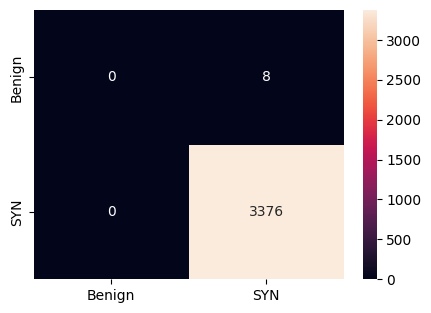





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    1        1        1     1      1      1      1        0.044     0.001
 1  SYN           0    2     0  RF    0.999    0.889    1     0.889  0.937  0.875  0.889    0.043     0.001
 2  SYN           0    3     0  RF    1        1        1     1      1      1      1        0.053     0.001
 3  SYN           0    4     0  RF    1        1        0.95  1      0.974  0.947  1        0.064     0
 4  SYN           0    5     0  RF    1        1        1     1      1      1      1        0.051     0.001
 5  SYN           0    1     1  RF    0.999    0.923    1     0.923  0.958  0.916  0.923    0.042     0
 6  SYN           0    2     1  RF    1        1        1     1      1      1      1        0.059     0.001
 7  SYN           0    3     1  

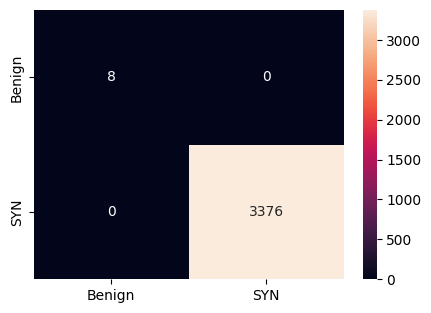





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.996    0.957   0.739  0.957  0.813  0.627  0.957    0.007     0.002
 1  SYN           0    2     0  NB    0.996    0.832   0.722  0.832  0.766  0.531  0.832    0.008     0.002
 2  SYN           0    3     0  NB    0.995    0.665   0.566  0.665  0.594  0.188  0.665    0.007     0.002
 3  SYN           0    4     0  NB    0.995    0.997   0.63   0.997  0.706  0.412  0.997    0.008     0.002
 4  SYN           0    5     0  NB    0.996    0.998   0.667  0.998  0.749  0.499  0.998    0.006     0.003
 5  SYN           0    1     1  NB    0.996    0.873   0.725  0.873  0.78   0.561  0.873    0.007     0.002
 6  SYN           0    2     1  NB    0.996    0.998   0.533  0.998  0.561  0.125  0.998    0.006     0.003
 7  SYN           0    3

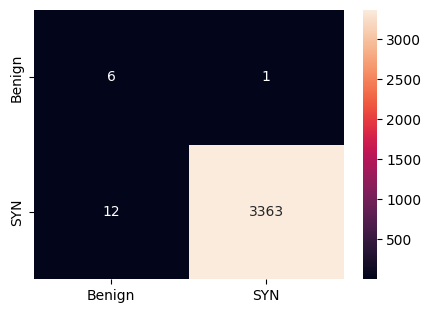





../csvs/mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Fwd IAT Tot', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd PSH Flags', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'RST Flag Cnt', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.682    0.599   0.827  0.599  0.561  0.23   0.599    0.414     0.

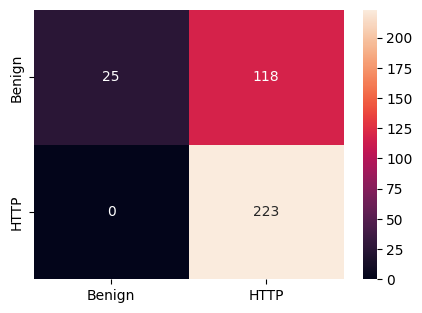





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.997    0.997   0.998  0.997  0.997  0.994  0.997    0.214     0.004
 1  HTTP          0    2     0  RF    0.997    0.996   0.998  0.996  0.997  0.994  0.996    0.198     0.005
 2  HTTP          0    3     0  RF    0.995    0.994   0.995  0.994  0.994  0.989  0.994    0.194     0.005
 3  HTTP          0    4     0  RF    0.992    0.991   0.992  0.991  0.991  0.983  0.991    0.189     0.005
 4  HTTP          0    5     0  RF    0.995    0.992   0.996  0.992  0.994  0.988  0.992    0.183     0.006
 5  HTTP          0    1     1  RF    1        1       1      1      1      1      1        0.215     0.005
 6  HTTP          0    2     1  RF    0.992    0.99    0.993  0.99   0.992  0.983  0.99     0.187     0.006
 7  HTTP          0    3

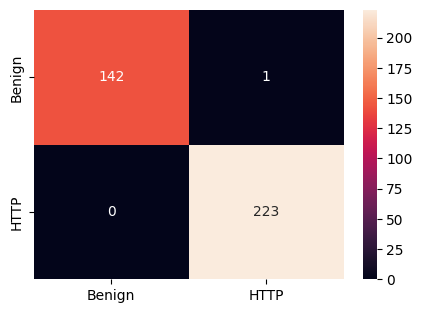





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.913    0.903   0.927  0.903  0.91   0.82   0.903    0.001     0.001
 1  HTTP          0    2     0  NB    0.932    0.906   0.949  0.906  0.922  0.845  0.906    0.001     0
 2  HTTP          0    3     0  NB    0.918    0.894   0.942  0.894  0.909  0.82   0.894    0.001     0.001
 3  HTTP          0    4     0  NB    0.889    0.863   0.915  0.863  0.877  0.758  0.863    0.001     0
 4  HTTP          0    5     0  NB    0.908    0.881   0.934  0.881  0.897  0.797  0.881    0         0.001
 5  HTTP          0    1     1  NB    0.929    0.902   0.947  0.902  0.919  0.839  0.902    0.001     0
 6  HTTP          0    2     1  NB    0.894    0.88    0.92   0.88   0.888  0.779  0.88     0.001     0
 7  HTTP          0    3     1  NB    0.

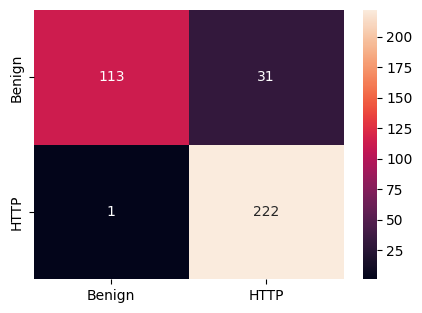





../csvs/mirai-ackflooding-4-dec.pcap_Flow.csv
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Max', 'Active Min', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.602    0.51    0.799  0.51   0.394  0.024  0.51     0.247     0.019
 1  ACK           0    2     0  SVM   0.559    0.505   0.779  0.505  0.367  0.01   0.505    0.246     0.019
 2  ACK           0    3     0  SVM   0.559    0.5     0.28   0.5

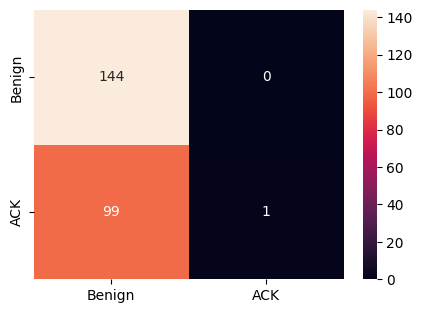





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF    1        1       1      1      1      1      1        0.052     0.001
 1  ACK           0    2     0  RF    1        1       1      1      1      1      1        0.045     0.001
 2  ACK           0    3     0  RF    1        1       1      1      1      1      1        0.047     0.001
 3  ACK           0    4     0  RF    0.992    0.991   0.991  0.991  0.991  0.982  0.991    0.043     0.001
 4  ACK           0    5     0  RF    0.992    0.993   0.991  0.993  0.992  0.983  0.993    0.044     0.002
 5  ACK           0    1     1  RF    0.992    0.989   0.993  0.989  0.991  0.983  0.989    0.045     0.001
 6  ACK           0    2     1  RF    1        1       1      1      1      1      1        0.044     0.001
 7  ACK           0    3

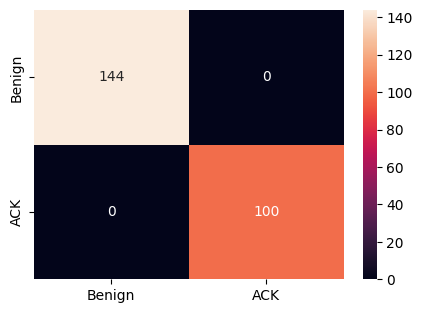





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.642    0.701   0.765  0.701  0.633  0.35   0.701    0             0
 1  ACK           0    2     0  NB    0.722    0.759   0.802  0.759  0.718  0.477  0.759    0.001         0
 2  ACK           0    3     0  NB    0.686    0.705   0.782  0.705  0.668  0.394  0.705    0.001         0
 3  ACK           0    4     0  NB    0.673    0.721   0.772  0.721  0.667  0.396  0.721    0.001         0
 4  ACK           0    5     0  NB    0.702    0.769   0.764  0.769  0.702  0.45   0.769    0.001         0
 5  ACK           0    1     1  NB    0.74     0.771   0.812  0.771  0.736  0.506  0.771    0             0
 6  ACK           0    2     1  NB    0.678    0.728   0.764  0.728  0.674  0.404  0.728    0.001         0
 7  ACK           0    3

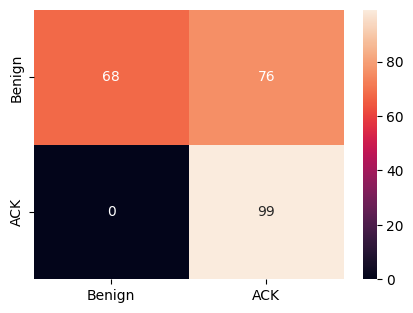





../csvs/mirai-udpflooding-2-dec.pcap_Flow.csv
['Src Port', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM   0.946      0.5   0.473    0.5  0.486      0    0.5    0.057     0.004
 1  UDP           0    2     0  SVM   0.987      0.5   0.493    0.5  0.497      0    0.5    0.057     0.005
 2  UDP           0    3     0  SVM   0.973      0.5   0.486    0.5  0.493      0    0.5    0.056     0.004
 3  UDP           0    4     0  SVM   0.986      0.5   0.493    0.5  0.497      0    0.5    0.056     0.004
 4  UDP           0    5     0  SVM   0.973      0.5   0.486    0.5  0.493      0    0.5    0.055     0.004
 5  UDP           0    1     1  SVM   0.966      0.5   0.483    0.5  0.491      0    0.5    0.055     0.005
 6  UDP           0    2     1  SVM   0.96       

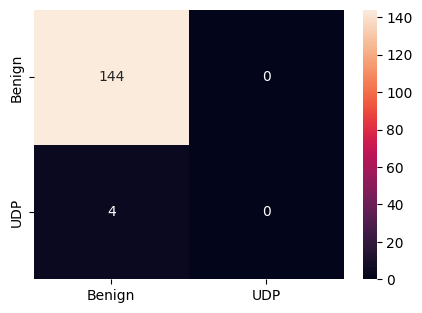





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  RF    0.993    0.917   0.997  0.917  0.953  0.906  0.917    0.154     0.004
 1  UDP           0    2     0  RF    1        1       1      1      1      1      1        0.156     0.003
 2  UDP           0    3     0  RF    0.993    0.833   0.997  0.833  0.898  0.797  0.833    0.148     0.003
 3  UDP           0    4     0  RF    0.986    0.8     0.993  0.8    0.872  0.744  0.8      0.139     0.003
 4  UDP           0    5     0  RF    0.98     0.743   0.663  0.743  0.695  0.39   0.743    0.139     0.004
 5  UDP           0    1     1  RF    0.987    0.75    0.993  0.75   0.83   0.661  0.75     0.14      0.003
 6  UDP           0    2     1  RF    1        1       1      1      1      1      1        0.142     0.004
 7  UDP           0    3

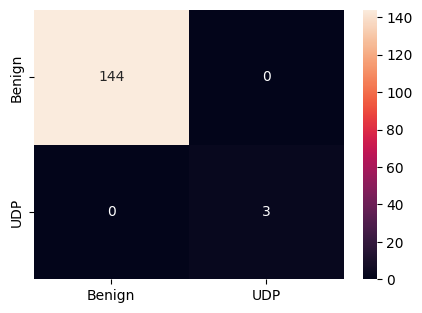





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.946    0.972   0.714  0.972  0.786  0.576  0.972    0             0
 1  UDP           0    2     0  NB    0.872    0.935   0.568  0.935  0.585  0.212  0.935    0.001         0
 2  UDP           0    3     0  NB    0.946    0.972   0.667  0.972  0.736  0.479  0.972    0             0
 3  UDP           0    4     0  NB    0.926    0.963   0.542  0.963  0.557  0.143  0.963    0.001         0
 4  UDP           0    5     0  NB    0.926    0.961   0.676  0.961  0.741  0.491  0.961    0.001         0
 5  UDP           0    1     1  NB    0.94     0.969   0.625  0.969  0.684  0.38   0.969    0.001         0
 6  UDP           0    2     1  NB    0.933    0.964   0.75   0.964  0.815  0.634  0.964    0             0
 7  UDP           0    3

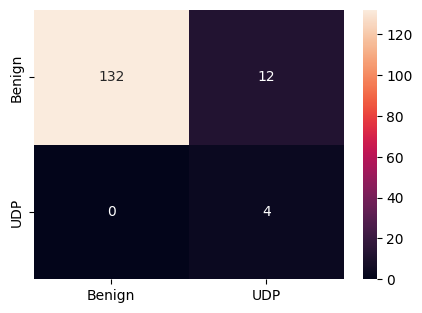





../csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Dst Port', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  SVM   0.394      0.5   0.197    0.5  0.283      0    0.5    0.035     0.004
 1  ARP           0    2     0  SVM   0.452      0.5   0.226  

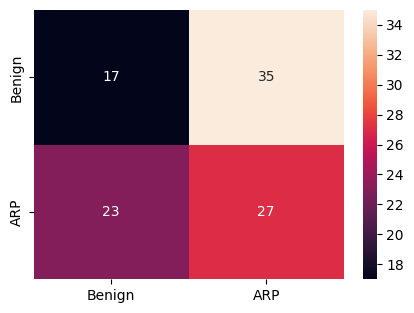





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.971    0.973   0.971  0.973  0.971  0.942  0.973    0.103     0.007
 1  ARP           0    2     0  RF    0.981    0.981   0.981  0.981  0.981  0.961  0.981    0.097     0.003
 2  ARP           0    3     0  RF    0.981    0.981   0.981  0.981  0.981  0.962  0.981    0.094     0.004
 3  ARP           0    4     0  RF    0.971    0.971   0.971  0.971  0.971  0.942  0.971    0.095     0.004
 4  ARP           0    5     0  RF    1        1       1      1      1      1      1        0.104     0.004
 5  ARP           0    1     1  RF    0.99     0.991   0.99   0.991  0.99   0.981  0.991    0.096     0.004
 6  ARP           0    2     1  RF    1        1       1      1      1      1      1        0.098     0.004
 7  ARP           0    3

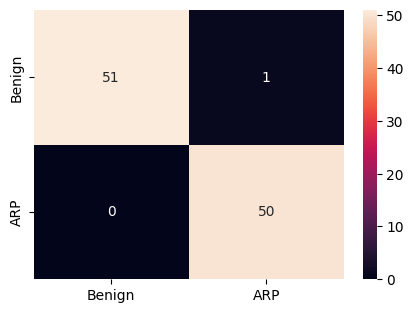





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.952    0.949   0.955  0.949  0.951  0.902  0.949    0         0
 1  ARP           0    2     0  NB    0.933    0.935   0.931  0.935  0.932  0.865  0.935    0         0
 2  ARP           0    3     0  NB    0.923    0.927   0.925  0.927  0.923  0.847  0.927    0.001     0
 3  ARP           0    4     0  NB    0.894    0.894   0.894  0.894  0.894  0.788  0.894    0.001     0
 4  ARP           0    5     0  NB    0.913    0.905   0.919  0.905  0.91   0.82   0.905    0.001     0
 5  ARP           0    1     1  NB    0.913    0.913   0.911  0.913  0.912  0.824  0.913    0         0
 6  ARP           0    2     1  NB    0.933    0.933   0.933  0.933  0.933  0.865  0.933    0.001     0
 7  ARP           0    3     1  NB    0.933    0.933

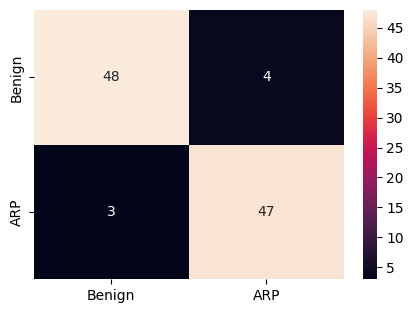





../csvs/scan-hostport-3-dec.pcap_Flow.csv
['Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Init Bwd Win Byts', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.957    0.625   0.978  0.625  0.689  0.386  0.625    0.037     0.004
 1  SP            0    2     0  SVM   0.961    0.556   0.981  0.556  0.59   0.193  0.556    0.025     0.002
 2  SP            0    3     0  SVM   0.961    0.5     0.481  0.5    0.49   0      0.5      0.026     0

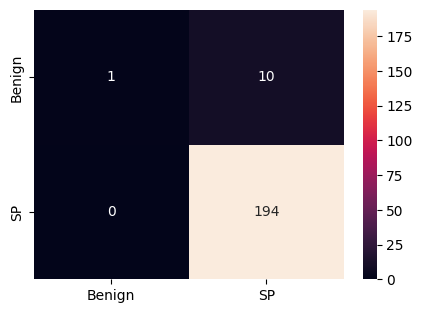





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  RF        1        1       1      1     1      1      1    0.039     0.001
 1  SP            0    2     0  RF        1        1       1      1     1      1      1    0.033     0.001
 2  SP            0    3     0  RF        1        1       1      1     1      1      1    0.035     0.001
 3  SP            0    4     0  RF        1        1       1      1     1      1      1    0.031     0.001
 4  SP            0    5     0  RF        1        1       1      1     1      1      1    0.032     0.001
 5  SP            0    1     1  RF        1        1       1      1     1      1      1    0.058     0.001
 6  SP            0    2     1  RF        1        1       1      1     1      1      1    0.041     0.001
 7  SP            0    3     1  R

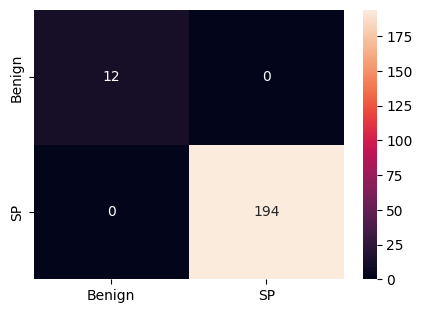





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.981    0.778   0.99   0.778  0.852  0.705  0.778    0.001     0
 1  SP            0    2     0  NB    0.971    0.858   0.951  0.858  0.898  0.797  0.858    0.001     0
 2  SP            0    3     0  NB    0.971    0.745   0.823  0.745  0.778  0.557  0.745    0.001     0
 3  SP            0    4     0  NB    0.961    0.779   0.932  0.779  0.836  0.673  0.779    0         0
 4  SP            0    5     0  NB    0.985    0.833   0.992  0.833  0.896  0.793  0.833    0.001     0
 5  SP            0    1     1  NB    0.976    0.808   0.987  0.808  0.875  0.75   0.808    0.001     0
 6  SP            0    2     1  NB    0.971    0.75    0.985  0.75   0.826  0.653  0.75     0         0.001
 7  SP            0    3     1  NB    0.99     0

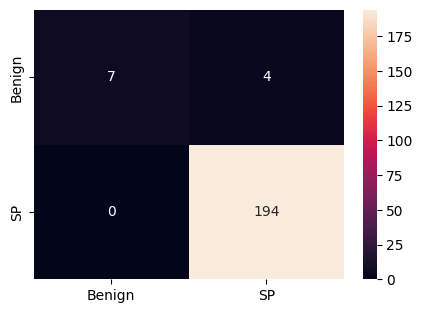





../csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkts/s', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.827    0.514   0.913  0.514  0.48   0.046  0.514    0.149     0.011
 1  BF            0    2     0  SVM   0.858    0.517   0.929  0.517  0.495  0.057  0.517    0.136     0.01
 2  BF            0    3     0  SVM   0.888    0.5     0.444  0.5    0.47   0      0.5      0.146     0.01
 3  BF            0    4     0  SVM   0.827    0.5     0.414  0.5    0.453  0      0.5      0.137     0.01
 4  BF            0    5     0  SVM   0.852    0.5     0.426  0.5    0.46   0      0.5      0.143     0.01
 5  BF            0

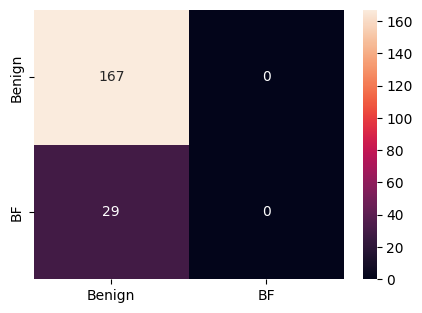





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.975    0.914   0.965  0.914  0.937  0.875  0.914    0.047     0.001
 1  BF            0    2     0  RF    0.98     0.95    0.974  0.95   0.962  0.923  0.95     0.045     0.001
 2  BF            0    3     0  RF    0.975    0.936   0.971  0.936  0.953  0.906  0.936    0.043     0.001
 3  BF            0    4     0  RF    0.985    0.948   0.991  0.948  0.968  0.937  0.948    0.042     0.001
 4  BF            0    5     0  RF    0.964    0.887   0.98   0.887  0.926  0.852  0.887    0.041     0.001
 5  BF            0    1     1  RF    0.98     0.926   0.989  0.926  0.954  0.908  0.926    0.042     0.001
 6  BF            0    2     1  RF    0.964    0.909   0.965  0.909  0.934  0.868  0.909    0.041     0
 7  BF            0    3    

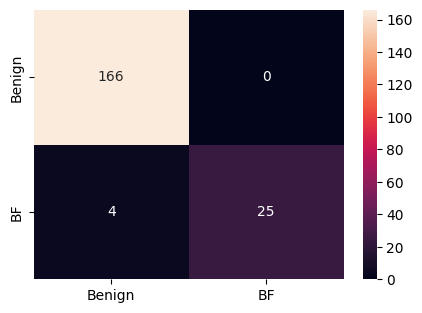





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF            0    1     0  NB    0.761    0.441   0.424  0.441  0.432  -0.132  0.441    0             0
 1  BF            0    2     0  NB    0.832    0.491   0.423  0.491  0.454  -0.028  0.491    0.001         0
 2  BF            0    3     0  NB    0.797    0.491   0.47   0.491  0.467  -0.026  0.491    0.001         0
 3  BF            0    4     0  NB    0.827    0.535   0.669  0.535  0.527   0.104  0.535    0.001         0
 4  BF            0    5     0  NB    0.832    0.494   0.485  0.494  0.482  -0.017  0.494    0             0
 5  BF            0    1     1  NB    0.772    0.463   0.452  0.463  0.456  -0.084  0.463    0.001         0
 6  BF            0    2     1  NB    0.858    0.53    0.683  0.53   0.524   0.093  0.53     0             0
 7  BF         

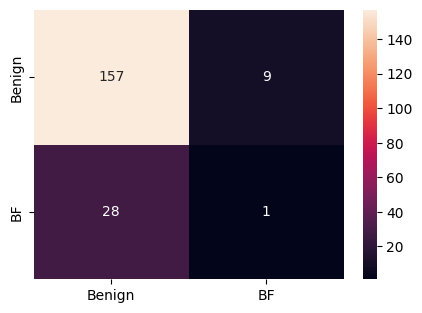

In [ ]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)


In [18]:
file_list = {
    "SYN": [
        "../csvs/dos-synflooding-1-dec.pcap_Flow.csv",
        "../csvs/dos-synflooding-2-dec.pcap_Flow.csv",
    ],
    "HTTP": [
        "../csvs/mirai-httpflooding-4-dec.pcap_Flow.csv",
        "../csvs/mirai-httpflooding-1-dec.pcap_Flow.csv",
    ],
    "ACK": [
        "../csvs/mirai-ackflooding-4-dec.pcap_Flow.csv",
        "../csvs/mirai-ackflooding-1-dec.pcap_Flow.csv",
    ],
    "UDP": [
        "../csvs/mirai-udpflooding-4-dec.pcap_Flow.csv",
        "../csvs/mirai-udpflooding-1-dec.pcap_Flow.csv",
    ],
    "ARP": [
        "../csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv",
        "../csvs/mitm-arpspoofing-4-dec.pcap_Flow.csv",
    ],
    "SP": [
        "../csvs/scan-hostport-3-dec.pcap_Flow.csv",
        "../csvs/scan-hostport-4-dec.pcap_Flow.csv",
    ],
    "BF": [
        "../csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv",
        "../csvs/mirai-hostbruteforce-3-dec.pcap_Flow.csv",
    ],
}


SYN
['Src Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.994      0.5   0.497    0.5  0.498      0    0.5  211.164

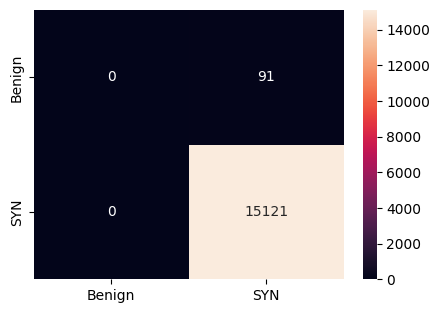





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    1        0.994   0.994  0.994  0.994  0.989  0.994    0.063     0.002
 1  SYN           0    1     1  RF    0.999    0.978   0.978  0.978  0.978  0.956  0.978    0.067     0.003
 2  SYN           0    1     2  RF    1        1       0.995  1      0.997  0.995  1        0.07      0.003
 3  SYN           0    1     3  RF    1        0.994   0.994  0.994  0.994  0.989  0.994    0.061     0.003
 4  SYN           0    1     4  RF    1        1       0.989  1      0.995  0.989  1        0.07      0.003
 5  SYN           0    1     5  RF    1        0.994   0.989  0.994  0.992  0.984  0.994    0.061     0.004
 6  SYN           0    1     6  RF    0.999    0.989   0.932  0.989  0.958  0.917  0.989    0.063     0.003
 7  SYN           0    1

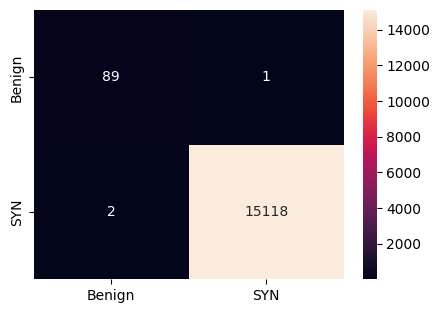





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.011     0.009
 1  SYN           0    1     1  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.009
 2  SYN           0    1     2  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.009
 3  SYN           0    1     3  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.01
 4  SYN           0    1     4  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.009
 5  SYN           0    1     5  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.01
 6  SYN           0    1     6  NB    0.994    0.915   0.753  0.915  0.814  0.628  0.915    0.009     0.008
 7  SYN           0    1  

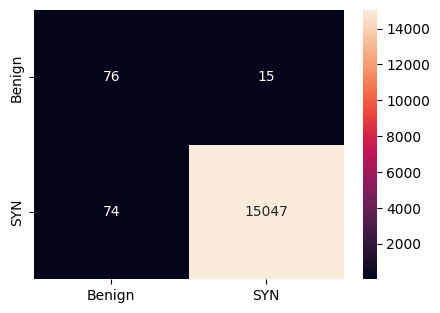





HTTP
['Dst Port', 'Protocol', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Fwd IAT Tot', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd PSH Flags', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'RST Flag Cnt', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.663    0.611   0.813  0.611  0.568  0.245  0.611    0.676     0.043
 1  HTTP          0    1     1  SVM   

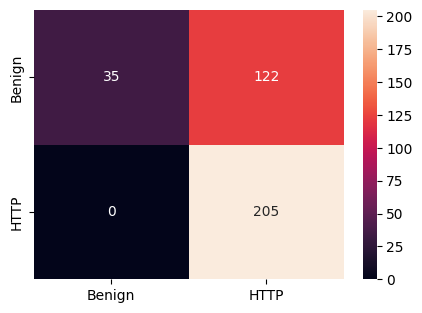





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.237     0.004
 1  HTTP          0    1     1  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.211     0.005
 2  HTTP          0    1     2  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.234     0.008
 3  HTTP          0    1     3  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.212     0.004
 4  HTTP          0    1     4  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.234     0.005
 5  HTTP          0    1     5  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.234     0.005
 6  HTTP          0    1     6  RF    0.994    0.994   0.995  0.994  0.994  0.989  0.994    0.218     0.005
 7  HTTP          0    1

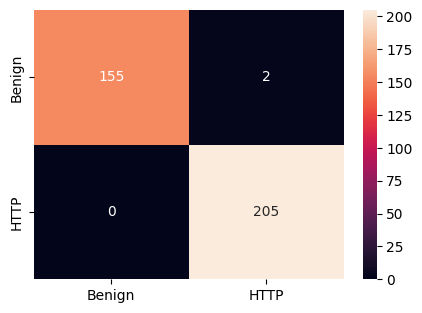





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.002     0
 1  HTTP          0    1     1  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.001     0
 2  HTTP          0    1     2  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.001     0
 3  HTTP          0    1     3  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.001     0
 4  HTTP          0    1     4  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.001     0.001
 5  HTTP          0    1     5  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.002     0
 6  HTTP          0    1     6  NB    0.856    0.834   0.899  0.834  0.844  0.696  0.834    0.001     0.001
 7  HTTP          0    1     7  NB    0.856 

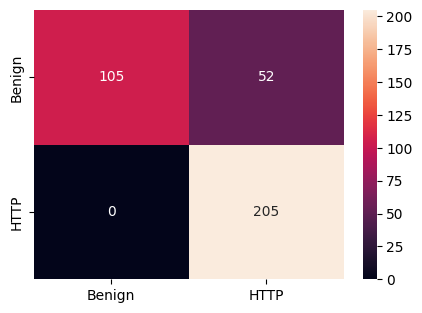





ACK
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Active Max', 'Active Min', 'Idle Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.029    0.504   0.511  0.504  0.029      0  0.504    1.484     8.453
 1  ACK           0    1     1  SVM   0.029    0.504   0.511  0.504  0.029      0  0.504    1.438     8.314
 2  ACK           0    1     2  SVM   0.029    0.504   0.511  0.504  0.029      0  0.504    1.418     8.317

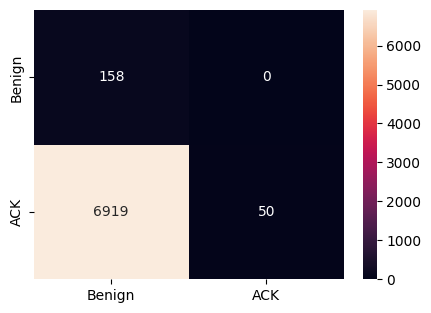





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF    0.998    0.99    0.964  0.99   0.976  0.953  0.99     0.057     0.007
 1  ACK           0    1     1  RF    0.997    0.992   0.951  0.992  0.971  0.941  0.992    0.049     0.007
 2  ACK           0    1     2  RF    0.996    0.992   0.919  0.992  0.952  0.905  0.992    0.049     0.008
 3  ACK           0    1     3  RF    0.997    0.989   0.95   0.989  0.969  0.938  0.989    0.05      0.007
 4  ACK           0    1     4  RF    0.995    0.988   0.916  0.988  0.949  0.899  0.988    0.048     0.007
 5  ACK           0    1     5  RF    0.997    0.989   0.945  0.989  0.966  0.932  0.989    0.049     0.008
 6  ACK           0    1     6  RF    0.997    0.989   0.943  0.989  0.965  0.929  0.989    0.049     0.007
 7  ACK           0    1

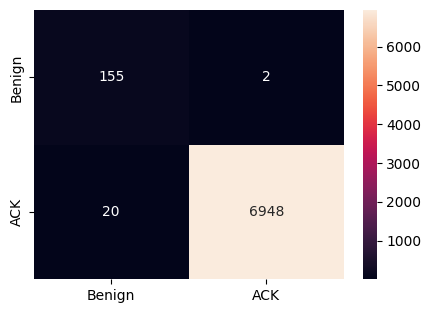





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0         0.003
 1  ACK           0    1     1  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0.001     0.003
 2  ACK           0    1     2  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0.001     0.004
 3  ACK           0    1     3  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0.001     0.003
 4  ACK           0    1     4  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0         0.003
 5  ACK           0    1     5  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0.002     0.003
 6  ACK           0    1     6  NB    0.639    0.522   0.502  0.522  0.412  0.005  0.522    0.001     0.003
 7  ACK           0    1

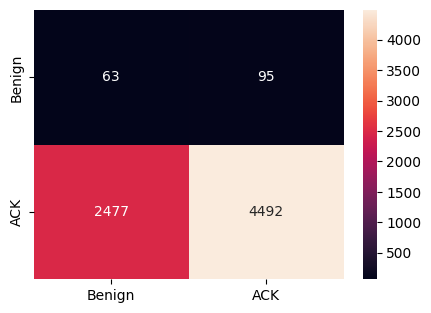





UDP
['Src Port', 'Fwd IAT Std', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.101     0.013
 1  UDP           0    1     1  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.085     0.013
 2  UDP           0    1     2  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.085     0.013
 3  UDP           0    1     3  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.086     0.014
 4  UDP           0    1     4  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.085     0.014
 5  UDP           0    1     5  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.085     0.013
 6  UDP           0    1     6  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5   

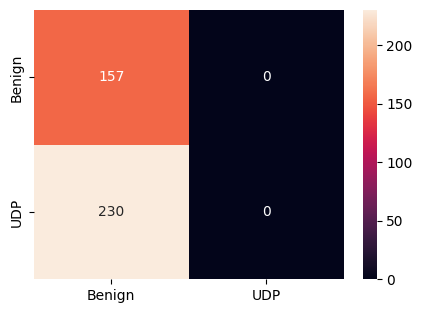





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.181     0.004
 1  UDP           0    1     1  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.15      0.005
 2  UDP           0    1     2  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.155     0.004
 3  UDP           0    1     3  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.155     0.004
 4  UDP           0    1     4  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.158     0.004
 5  UDP           0    1     5  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.151     0.004
 6  UDP           0    1     6  RF    0.974    0.978    0.97  0.978  0.973  0.947  0.978    0.156     0.005
 7  UDP           0    1

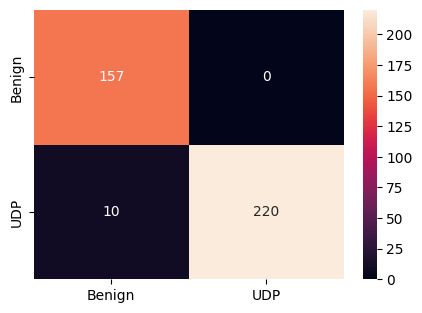





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0             0
 1  UDP           0    1     1  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0.002         0
 2  UDP           0    1     2  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0.001         0
 3  UDP           0    1     3  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0.001         0
 4  UDP           0    1     4  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0.001         0
 5  UDP           0    1     5  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0.001         0
 6  UDP           0    1     6  NB    0.853    0.873   0.862  0.873  0.852   0.71  0.873    0             0
 7  UDP           0    1

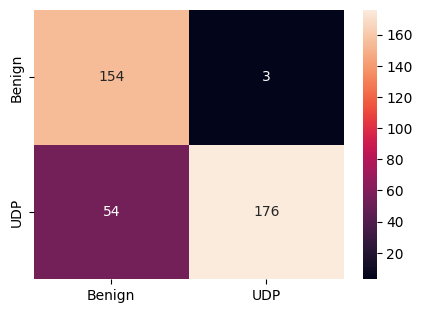





ARP
['Src Port', 'Dst Port', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Byts', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  SVM   0.335      0.5   0.168    0.5  0.251      0    0.5    0.056     0.013
 1  ARP           0    1     1  SVM   0.335      0.5   0.168    0.5  0.251      0    0.5    0.055     0

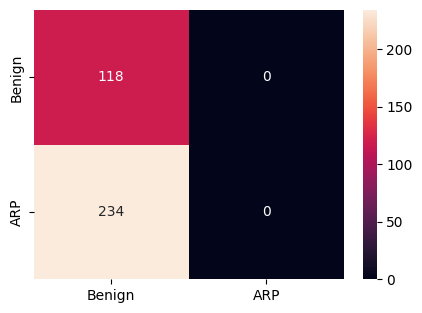





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.991    0.989   0.991  0.989  0.99   0.981  0.989    0.109     0.007
 1  ARP           0    1     1  RF    0.991    0.987   0.994  0.987  0.99   0.981  0.987    0.102     0.007
 2  ARP           0    1     2  RF    0.994    0.992   0.996  0.992  0.994  0.987  0.992    0.098     0.006
 3  ARP           0    1     3  RF    0.991    0.989   0.991  0.989  0.99   0.981  0.989    0.096     0.007
 4  ARP           0    1     4  RF    0.986    0.981   0.987  0.981  0.984  0.968  0.981    0.095     0.006
 5  ARP           0    1     5  RF    0.986    0.981   0.987  0.981  0.984  0.968  0.981    0.098     0.005
 6  ARP           0    1     6  RF    0.989    0.983   0.992  0.983  0.987  0.974  0.983    0.096     0.006
 7  ARP           0    1

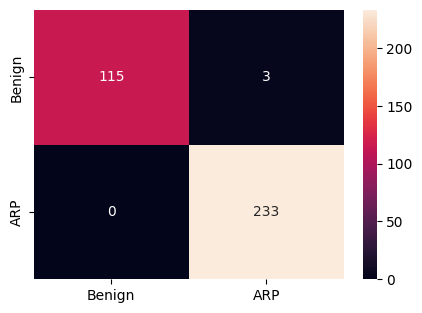





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0         0
 1  ARP           0    1     1  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0.001     0
 2  ARP           0    1     2  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0.001     0
 3  ARP           0    1     3  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0         0
 4  ARP           0    1     4  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0.001     0
 5  ARP           0    1     5  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0.001     0
 6  ARP           0    1     6  NB    0.903    0.875   0.906  0.875  0.888  0.776  0.875    0.001     0
 7  ARP           0    1     7  NB    0.903    0.875

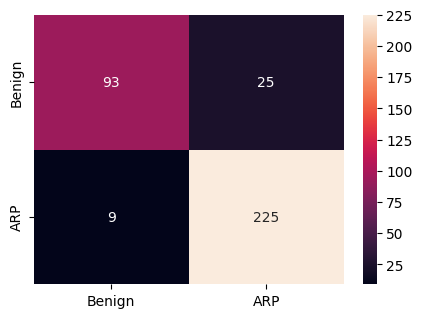





SP
['Protocol', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Byts', 'Init Bwd Win Byts', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.908     0.51   0.954   0.51  0.495  0.035   0.51    0.038     0.012
 1  SP            0    1     1  SVM   0.908     0.51   0.954   0.51  0.495  0.035   0.51    0.039     0.011
 2  SP            0    1     2  SVM   0.908     0.51   0.954   0.51  0.495  0.035   0.51    0.037     0.011
 3  SP            0    1     3  SV

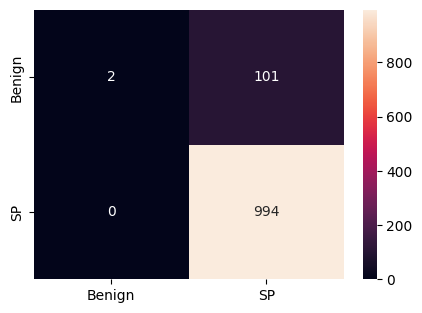





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.038     0.001
 1  SP            0    1     1  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.032     0.002
 2  SP            0    1     2  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.037     0.001
 3  SP            0    1     3  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.033     0.002
 4  SP            0    1     4  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.033     0.001
 5  SP            0    1     5  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.033     0.002
 6  SP            0    1     6  RF    0.999    0.995   0.999  0.995  0.997  0.995  0.995    0.033     0.001
 7  SP            0    1

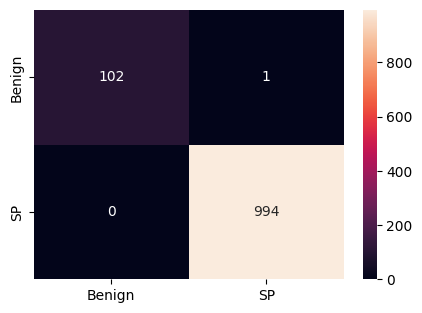





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0.001     0
 1  SP            0    1     1  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0.001     0
 2  SP            0    1     2  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0.001     0
 3  SP            0    1     3  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0.001     0
 4  SP            0    1     4  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0         0
 5  SP            0    1     5  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0         0.001
 6  SP            0    1     6  NB    0.965    0.816   0.982  0.816  0.878  0.756  0.816    0.001     0
 7  SP            0    1     7  NB    0.965    0

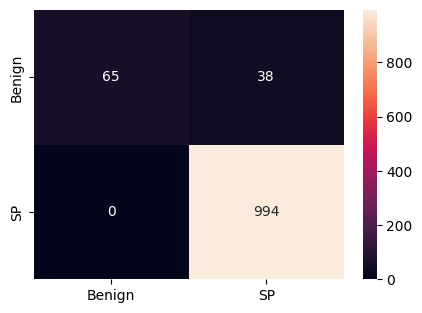





BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkts/s', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.851    0.514   0.925  0.514  0.486  0.046  0.514    0.216     0.068
 1  BF            0    1     1  SVM   0.851    0.514   0.925  0.514  0.486  0.046  0.514    0.234     0.068
 2  BF            0    1     2  SVM   0.851    0.514   0.925  0.514  0.486  0.046  0.514    0.21      0.068
 3  BF            0    1     3  SVM   0.851    0.514   0.925  0.514  0.486  0.046  0.514    0.212     0.069
 4  BF            0    1     4  SVM   0.851    0.514   0.925  0.514  0.486  0.046  0.514    0.223     0.068
 5  BF            0    1     5  SVM   0.851    0.514   0.925 

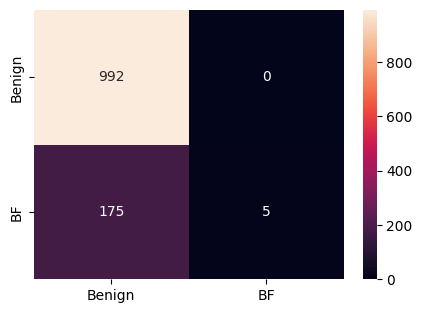





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.963    0.903   0.952  0.903  0.925  0.851  0.903    0.061     0.002
 1  BF            0    1     1  RF    0.962    0.898   0.951  0.898  0.922  0.843  0.898    0.051     0.002
 2  BF            0    1     2  RF    0.956    0.883   0.944  0.883  0.91   0.821  0.883    0.049     0.002
 3  BF            0    1     3  RF    0.96     0.892   0.949  0.892  0.918  0.836  0.892    0.047     0.002
 4  BF            0    1     4  RF    0.959    0.898   0.939  0.898  0.917  0.835  0.898    0.049     0.001
 5  BF            0    1     5  RF    0.961    0.884   0.963  0.884  0.918  0.836  0.884    0.056     0.003
 6  BF            0    1     6  RF    0.967    0.905   0.964  0.905  0.932  0.864  0.905    0.054     0.001
 7  BF            0    1

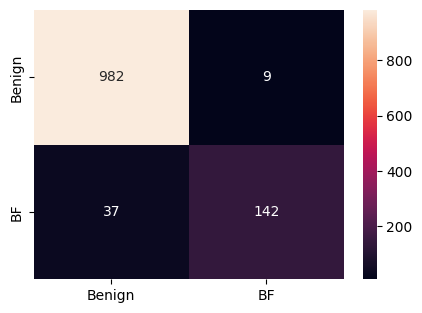





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 1  BF            0    1     1  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 2  BF            0    1     2  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 3  BF            0    1     3  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 4  BF            0    1     4  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.002         0
 5  BF            0    1     5  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 6  BF            0    1     6  NB    0.821    0.512   0.536  0.512  0.502  0.034  0.512    0.001         0
 7  BF            0    1

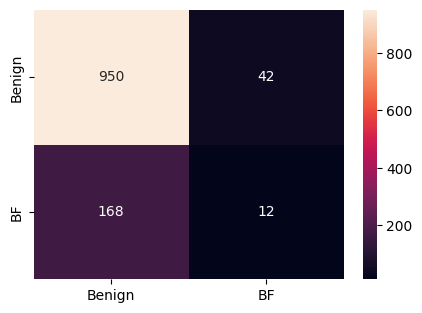

In [19]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)

### TEST

In [ ]:
file_list={
# "SYN":[ '../csvs/dos-synflooding-1-dec.pcap_Flow.csv', '../csvs/dos-synflooding-5-dec.pcap_Flow.csv',],
# "HTTP":['../csvs/DDoS HTTP Flood Attacks.pcap_Flow.csv', '../csvs/mirai-httpflooding-4-dec.pcap_Flow.csv'],
# "ACK":['../csvs/mirai-ackflooding-3-dec.pcap_Flow.csv','../csvs/mirai-ackflooding-4-dec.pcap_Flow.csv'],
# "UDP":[ '../csvs/mirai-udpflooding-4-dec.pcap_Flow.csv','../csvs/UDP_DDoS_00001.pcap_Flow.csv'],
# "ARP":[ '../csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv', '../csvs/mitm-arpspoofing-2-dec.pcap_Flow.csv'],
# "SP":['../csvs/Edge Port Scanning attack.pcap_Flow.csv','../csvs/scan-hostport-3-dec.pcap_Flow.csv'],
"BF":[ '../csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv','../csvs/Edge Password attacks.pcap_Flow.csv']}

BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Pkts/s', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            1    1     0  SVM   0.538      0.5   0.269    0.5  0.35      0    0.5    0.22     11.459
 1  BF            1    1     1  SVM   0.538      0.5   0.269    0.5  0.35      0    0.5    0.212    11.296
 2  BF            1    1     2  SVM   0.538      0.5   0.269    0.5  0.35      0    0.5    0.218    11.303
 3  BF            1    1     3  SVM   0.538      0.5   0.269    0.5  0.35      0    0.5    0.215    11.429
 4  BF            1    1     4  SVM   0.538      0.5   0.269    0.5  0.35      0    0.5    0.22     12.198
 5  BF            1    1     5  SVM   0.538      0.5   0.269    0.5  0.3

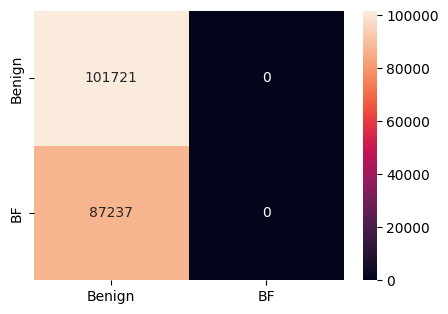





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  RF    0.749    0.728   0.836  0.728  0.719  0.474  0.728    0.048     0.127
 1  BF            1    1     1  RF    0.601    0.568   0.782  0.568  0.486  0.146  0.568    0.051     0.136
 2  BF            1    1     2  RF    0.733    0.712   0.824  0.712  0.7    0.442  0.712    0.049     0.132
 3  BF            1    1     3  RF    0.748    0.728   0.835  0.728  0.719  0.473  0.728    0.049     0.132
 4  BF            1    1     4  RF    0.727    0.705   0.827  0.705  0.69   0.428  0.705    0.048     0.131
 5  BF            1    1     5  RF    0.69     0.666   0.803  0.666  0.639  0.347  0.666    0.049     0.133
 6  BF            1    1     6  RF    0.746    0.725   0.833  0.725  0.716  0.468  0.725    0.052     0.13
 7  BF            1    1 

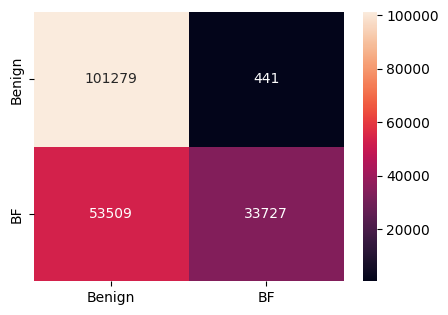





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  ------  -----  -------  --------
 0  BF            1    1     0  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.002     0.037
 1  BF            1    1     1  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.035
 2  BF            1    1     2  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.039
 3  BF            1    1     3  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.033
 4  BF            1    1     4  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.036
 5  BF            1    1     5  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.038
 6  BF            1    1     6  NB    0.538      0.5   0.269    0.5  0.35  -0.001    0.5    0.001     0.034
 7  BF            1    1

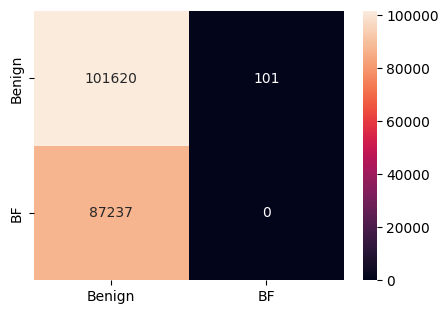

In [ ]:
folder("results/test/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)

In [18]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]

for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df = df.mean(numeric_only=True)
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

100%|██████████| 21/21 [00:00<00:00, 114.71it/s]

    Attack    ML            Acc     b_Acc         Prec       Rec           F1           kap       ROC          tra-T        test-T
--  --------  ----  -----------  --------  -----------  --------  -----------  ------------  --------  -------------  ------------
 0  ACK       NB    0.718597     0.733281  0.727221     0.733281  0.717899      0.445153     0.733281    0.00283144    0.000300074
 1  ACK       RF    0.864274     0.839402  0.894851     0.839402  0.847078      0.702593     0.839402    0.207869      0.0019098
 2  ACK       SVM   0.420065     0.508299  0.707166     0.508299  0.309279      0.0136598    0.508299   12.866         0.631096
 3  ARP       NB    0.533333     0.58      0.531606     0.58      0.449057      0.0634291    0.58        0.000594449   0.000214243
 4  ARP       RF    0.661778     0.52625   0.512116     0.52625   0.486968      0.0294199    0.52625     0.0974214     0.0046989
 5  ARP       SVM   0.888889     0.5       0.444444     0.5       0.470588      0         

In [19]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

ACK
ARP
BF
HTTP
SP
SYN
UDP
